# **Task: Build and train a CNN model from scratch using PyTorch**

### **Steps to build a CNN model from scratch using PyTorch:**

1. Define the convolution and max-pooling operations.
2. Implement the `convolutional` layer with forward and backward operations.
3. Implement the `max-pooling` layer with forward and backward operations.
4. Define the `BCE loss` function along with its derivative.
5. Implement a `dense` (fully connected) layer with forward and backward operations.
6. Implement an `activation layer` with forward and backward operations.
7. Implement a `reshape` layer with forward and backward operations.
8. Set up the `training loop`.
9. `Configure` the network architecture.
10. `Train` the model.

### **Note:** 
The notebook includes pre-defined `convolution2d()` and `max_pool2d()` operations. 

In [ ]:
import torch
import torch.nn.functional as F

# 2D Convolution Function
def convolution2d(input_matrix, kernel, padding=0, stride=1):
    # Add padding if required
    if padding > 0:
        input_matrix = F.pad(input_matrix, (padding, padding, padding, padding))

    # Get dimensions of the padded input and kernel
    input_height, input_width = input_matrix.shape[-2:]
    kernel_height, kernel_width = kernel.shape[-2:]

    # Calculate the dimensions of the output matrix
    output_height = (input_height - kernel_height) // stride + 1
    output_width = (input_width - kernel_width) // stride + 1

    # Initialize the output matrix with zeros
    output_matrix = torch.zeros(output_height, output_width)

    # Perform the convolution operation
    for i in range(0, output_height * stride, stride):
        for j in range(0, output_width * stride, stride):
            # Extract the region of the input that the kernel will multiply with
            region = input_matrix[..., i:i+kernel_height, j:j+kernel_width]

            # Perform element-wise multiplication and sum the result
            output_matrix[i // stride, j // stride] = torch.sum(region * kernel)

    return output_matrix

# Max Pooling Function
def max_pool2d(input_matrix, kernel_size, stride):
    input_height, input_width = input_matrix.shape[-2:]
    kernel_height, kernel_width = kernel_size
    stride_height, stride_width = stride

    output_height = (input_height - kernel_height) // stride_height + 1
    output_width = (input_width - kernel_width) // stride_width + 1

    output_matrix = torch.zeros((output_height, output_width))
    max_indices = torch.zeros((output_height, output_width, 2), dtype=torch.int64)  # To store max indices

    for i in range(0, output_height * stride_height, stride_height):
        for j in range(0, output_width * stride_width, stride_width):
            region = input_matrix[i:i + kernel_height, j:j + kernel_width]
            max_value = torch.max(region)

            # Find the indices of the maximum value
            max_idx = (region == max_value).nonzero()[0]  # Select the first occurrence of the max value
            output_matrix[i // stride_height, j // stride_width] = max_value
            max_indices[i // stride_height, j // stride_width] = torch.tensor([max_idx[0] + i, max_idx[1] + j])

    return output_matrix, max_indices

### **Implement a Convolutional Layer in PyTorch**
Objective: In this exercise, you are going to implement a 2D Convolutional layer using PyTorch. You will define a custom Convolutional class that can compute the forward and backward passes of a convolution operation. The goal is to understand how a convolutional layer processes images or other data with spatial structure.

**Instructions**
* Initialize the Convolutional Layer:

  * Define the class Convolutional to initialize the convolutional layer with a given input_shape (depth, height, width), a kernel_size, and a specified depth for the number of filters.
  * Initialize the kernels (filters) randomly using torch.randn with the size (depth, input_depth, kernel_size, kernel_size).
  * Initialize the biases randomly for each filter using torch.randn with the output shape.
* Forward Pass:

  * Implement the forward method which computes the convolution operation for the input using the kernels and adds the biases.
  * Use a 2D convolution operation for each channel, followed by adding the bias.
* Backward Pass:

  * Implement the backward method to compute the gradients for both the kernels and the input with respect to the loss.
  * Use the flipped version of the kernel for the backward convolution and adjust the kernel and bias parameters using gradient descent. `torch.flip()` is a function in PyTorch used to reverse the order of elements in a tensor along specified dimensions (axes).
  `torch.flip(input, dims)`
    * input: The input tensor to flip.
    * dims: A tuple or list of dimensions along which to flip the tensor.


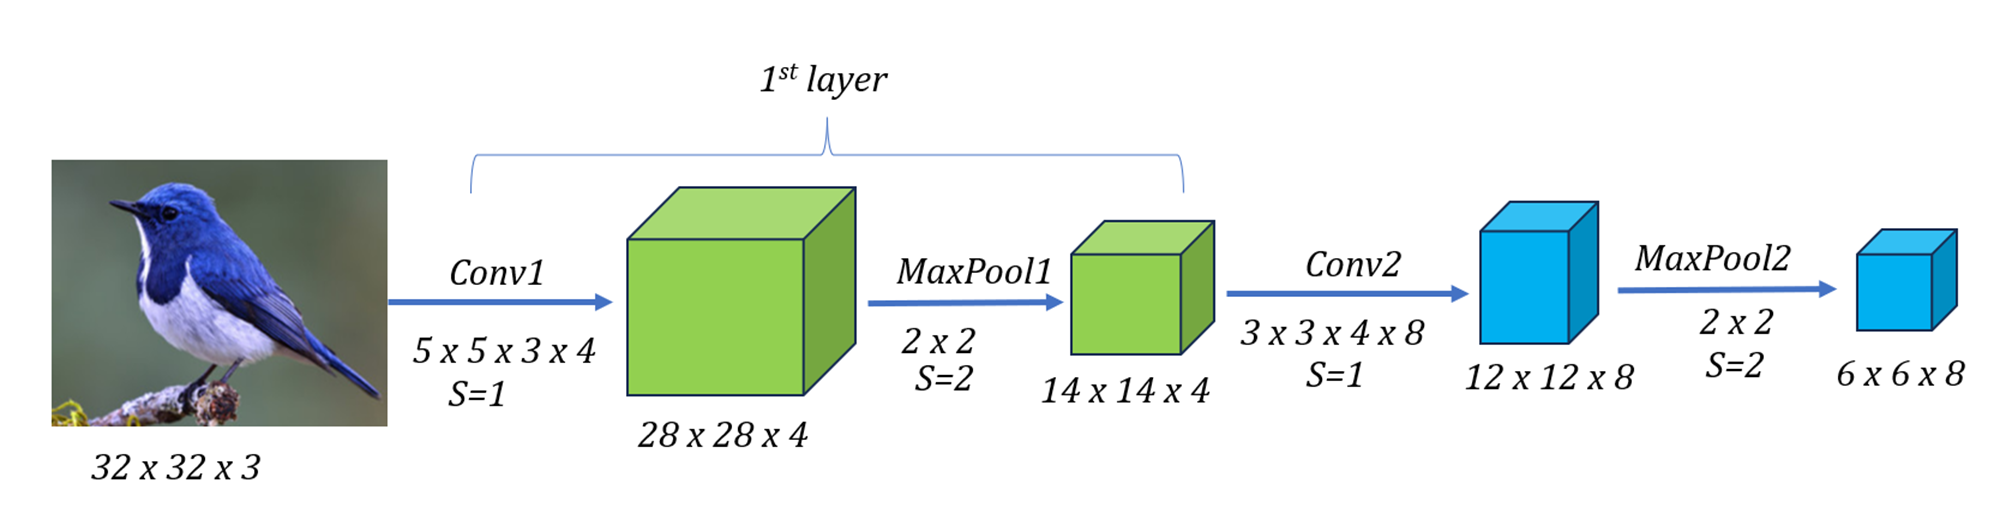

In [ ]:
# Convolutional Layer
class Convolutional:
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = torch.randn(*self.kernels_shape, dtype=torch.float32)
        self.biases = torch.randn(depth, 1, 1, dtype=torch.float32)  # Biases for each depth (added per channel)

    def forward(self, input):
        self.input = input
        # Initialize the output tensor, without including biases yet
        self.output = torch.zeros(self.output_shape, dtype=torch.float32)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += convolution2d(self.input[j], self.kernels[i, j])
            # Add bias for each output channel after summing the input channels
            self.output[i] += self.biases[i]

        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = torch.zeros(self.kernels_shape)
        input_gradient = torch.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = convolution2d(self.input[j], output_gradient[i])
                flipped_kernel = torch.flip(self.kernels[i, j], dims=(0, 1))
                input_gradient[j] += convolution2d(output_gradient[i], flipped_kernel, padding=self.kernels_shape[2]-1)

        # Update kernels and biases
        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * torch.sum(output_gradient, dim=(1,2), keepdim=True)
        return input_gradient


In [ ]:
import torch

# Instantiate the Convolutional Layer
input_shape = (1, 5, 15)  # Example input shape (depth=1, height=5, width=5)
kernel_size = 3          # Kernel size
depth = 1                # Number of output channels (filters)

conv_layer = Convolutional(input_shape, kernel_size, depth)

# Example Input: A random 5x5 tensor
input_data = torch.randn(input_shape)

# Perform a Forward Pass
output = conv_layer.forward(input_data)
print("Forward Output:")
print(output)
print(output.shape)

# Example Gradient from the Next Layer (Random for demonstration)
output_gradient = torch.randn(conv_layer.output_shape)

# Perform a Backward Pass (Update weights and biases)
learning_rate = 0.01
input_gradient = conv_layer.backward(output_gradient, learning_rate)

print("\nBackward Input Gradient:")
print(input_gradient)
print(input_gradient.shape)


In [2]:
# Output:
# Forward Output:
# tensor([[[ 0.8704,  2.4435,  2.4411,  2.2659,  0.4451,  1.5637,  6.2568,
#            7.3787,  4.9550,  4.5788,  0.9430,  3.2169,  0.4498],
#          [-3.4921, -1.0772,  6.6277, -2.2830, -3.9163,  2.5759,  0.7506,
#           -2.5678,  1.1853,  5.3143,  3.5873,  4.2030, -0.8944],
#          [-4.1456,  5.9766,  2.0323, -0.2845,  1.7483,  4.0194,  0.9113,
#            1.8994, -3.9143,  2.1743,  3.7536, -1.0166,  2.8621]]])
# torch.Size([1, 3, 13])

# Backward Input Gradient:
# tensor([[[ 1.2584, -0.4415,  1.6344,  0.1930,  2.8832, -1.1412, -1.2959,
#            1.3257,  1.3269,  0.3185, -1.0201,  0.0930, -0.5117,  0.0596,
#            0.0745],
#          [-1.9796,  1.0392,  2.3077,  1.1328, -0.4068,  3.9040,  2.1458,
#            0.2634, -1.9047,  0.3898,  4.4800, -0.5507,  1.0645, -0.2418,
#           -0.8306],
#          [ 1.0839, -1.9993, -0.9514, -1.7189,  0.3267, -2.9222,  3.5495,
#            1.4382, -3.2283, -0.4312, -1.3733,  0.1245,  1.3049,  0.7563,
#            1.4963],
#          [ 0.0289,  1.7193, -1.0416, -1.7223,  1.2017,  0.3903, -4.5209,
#            1.5460, -1.9710,  2.1279, -1.7786, -3.9698,  1.0202, -3.8281,
#            0.9857],
#          [-0.1852, -0.7945,  0.3612, -0.6610,  0.7731,  2.0114, -0.6650,
#           -0.2293,  0.4311,  1.4677,  1.2209, -0.4773,  1.5323, -0.8409,
#           -0.0148]]])
# torch.Size([1, 5, 15])

### **Implementing Max Pooling Layer**
In this exercise, you will work with a custom implementation of the Max Pooling layer. Max pooling is commonly used in Convolutional Neural Networks (CNNs) to reduce the spatial dimensions (height and width) of the input while retaining the most important features. This layer helps in reducing computational cost and controlling overfitting by reducing the number of parameters in the model.

**Instructions:**
* Initialization:

  * Define the kernel size (the size of the pooling window).
  * Define the stride (the step size by which the pooling window moves across the input).
* Forward Method:

  * In the forward() method, store the input matrix for later use during backpropagation.
  * Call the external max_pool2d() function to compute the max-pooled output and store the indices of the maximum values.
  * The max_pool2d() function returns both the pooled output matrix and the indices of the maximum values within the pooling regions.

* Backward Method:

  * In the backward() method, initialize a gradient matrix of the same shape as the input.
  * Propagate the gradients backward using the stored indices from the forward pass, assigning each gradient back to the location of the maximum value in the input matrix.

In [ ]:
class MaxPool2D:
    def __init__(self, kernel_size, stride):
        self.kernel_size = kernel_size
        self.stride = stride
        self.input_matrix = None
        self.output_matrix = None
        self.max_indices = None

    def forward(self, input_matrix):
        # Store input matrix for use in the backward pass
        self.input_matrix = input_matrix
        # Call the external max_pool2d() function
        self.output_matrix, self.max_indices = max_pool2d(input_matrix, self.kernel_size, self.stride)
        return self.output_matrix

    def backward(self, output_gradient, learning_rate):
        # Initialize the input gradient matrix (same shape as input_matrix)
        input_gradient = torch.zeros_like(self.input_matrix)

        # For each gradient, assign it back to the correct max index location
        for i in range(output_gradient.shape[0]):
            for j in range(output_gradient.shape[1]):
                max_row, max_col = self.max_indices[i, j]
                input_gradient[max_row, max_col] = output_gradient[i, j]
        return input_gradient

In [ ]:
# Example usage
import torch

input_tensor = torch.tensor([[1, 2, 3, 4],
                             [5, 6, 7, 8],
                             [9, 10, 11, 12],
                             [13, 14, 15, 16]], dtype=torch.float32)

kernel_size = (2, 2)
stride = (2, 2)

# Forward Pass
maxpool_layer = MaxPool2D(kernel_size, stride)
output_tensor = maxpool_layer.forward(input_tensor)

print("Input Tensor:\n", input_tensor)
print("\nOutput Tensor (Forward Pass):\n", output_tensor)

# Example gradient from the next layer
grad_output = torch.tensor([[1.0, 0.5],
                            [2.0, 1.5]], dtype=torch.float32)

# Backward Pass
learning_rate = 0.01
grad_input = maxpool_layer.backward(grad_output, learning_rate)

print("\nGradient Output:\n", grad_output)
print("\nGradient Input (Backward Pass):\n", grad_input)

In [ ]:
# Output:
# Input Tensor:
#  tensor([[ 1.,  2.,  3.,  4.],
#         [ 5.,  6.,  7.,  8.],
#         [ 9., 10., 11., 12.],
#         [13., 14., 15., 16.]])

# Output Tensor (Forward Pass):
#  tensor([[ 6.,  8.],
#         [14., 16.]])

# Gradient Output:
#  tensor([[1.0000, 0.5000],
#         [2.0000, 1.5000]])

# Gradient Input (Backward Pass):
#  tensor([[0.0000, 0.0000, 0.0000, 0.0000],
#         [0.0000, 1.0000, 0.0000, 0.5000],
#         [0.0000, 0.0000, 0.0000, 0.0000],
#         [0.0000, 2.0000, 0.0000, 1.5000]])

### **Implementing Binary Cross-Entropy Loss and Its Derivative**
**Objective:**
In this exercise, you are going to implement the Binary Cross-Entropy (BCE) Loss and its derivative using PyTorch tensors. Binary Cross-Entropy is commonly used in binary classification problems, and understanding its calculation and gradient is essential for training machine learning models.

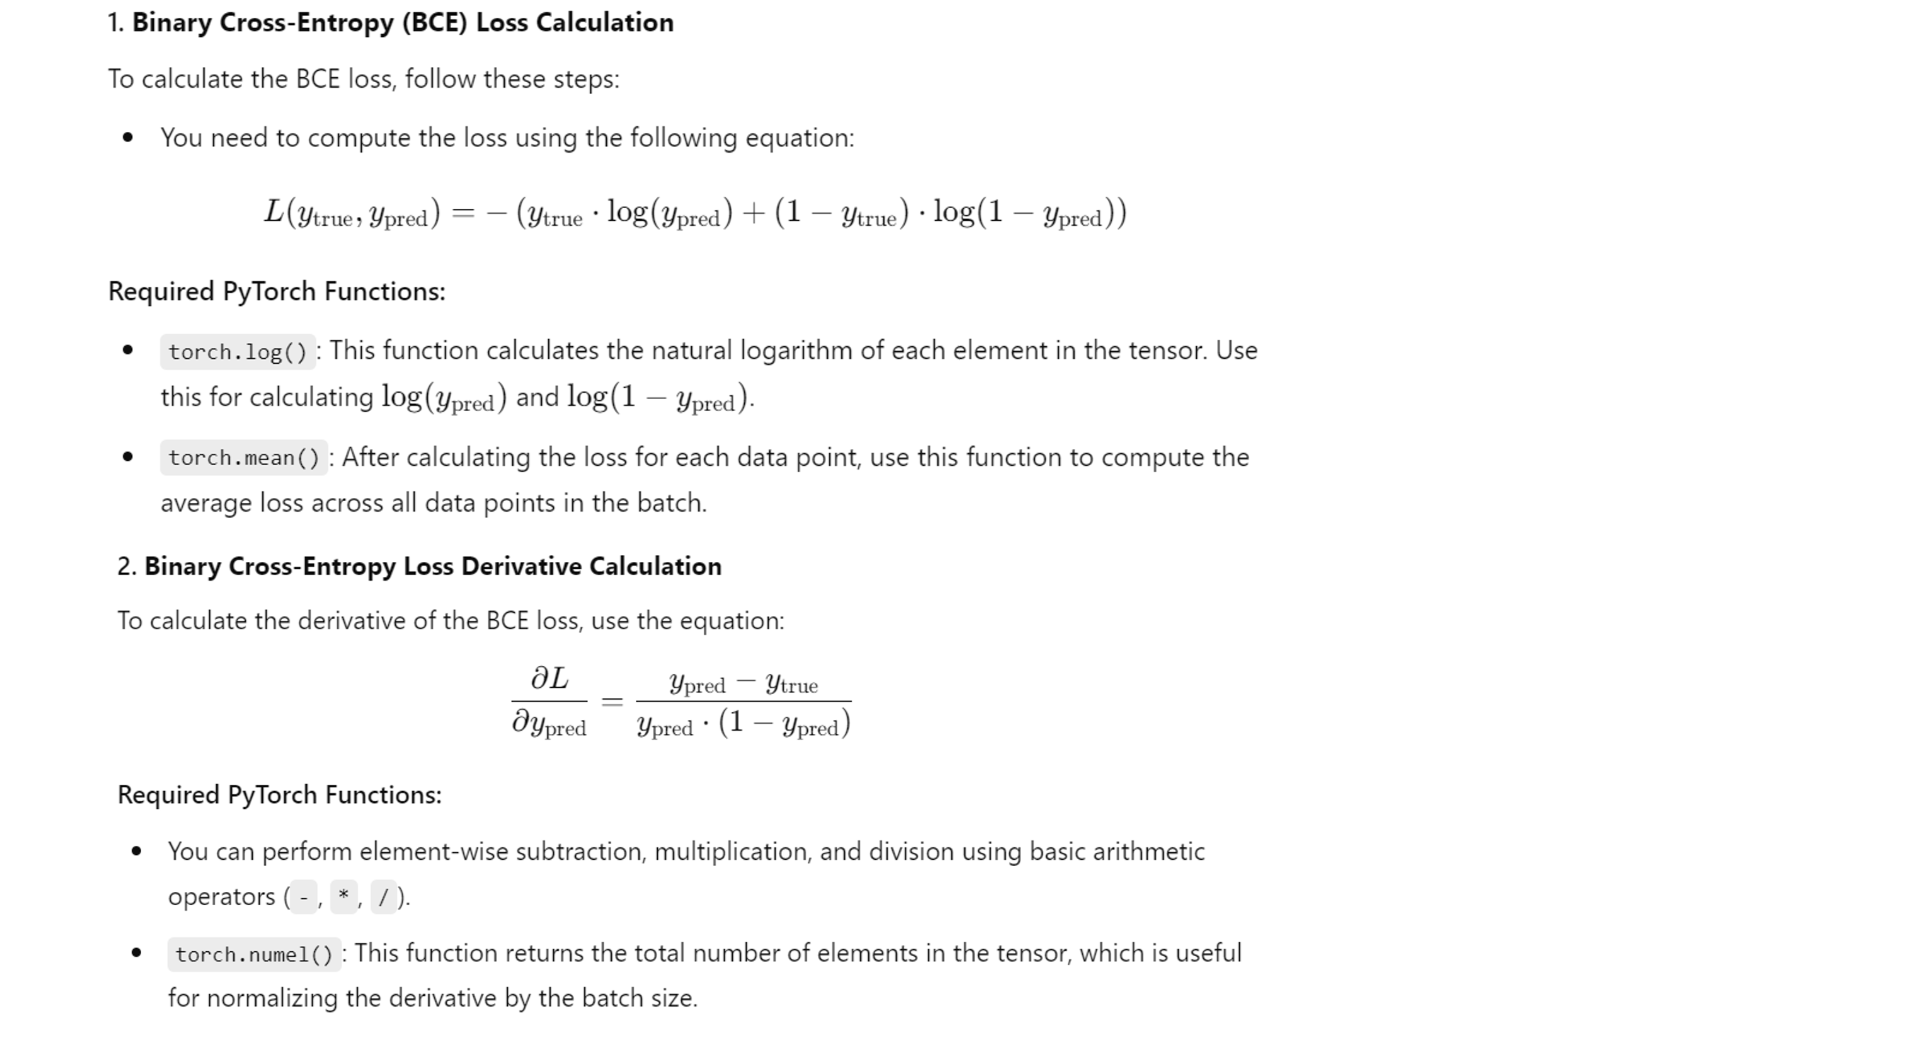

In [ ]:
import torch

# Binary Cross-Entropy Loss
def binary_cross_entropy(y_true, y_pred):
    """
    Compute the Binary Cross-Entropy Loss between true labels and predictions.

    Args:
    y_true (torch.Tensor): Tensor containing true labels (0 or 1).
    y_pred (torch.Tensor): Tensor containing predicted probabilities (values between 0 and 1).

    Returns:
    torch.Tensor: The computed Binary Cross-Entropy loss.
    """
    return torch.mean(-y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred))

# Binary Cross-Entropy Derivative
def binary_cross_entropy_derivative(y_true, y_pred):
    """
    Compute the derivative of the Binary Cross-Entropy Loss with respect to the predictions.

    Args:
    y_true (torch.Tensor): Tensor containing true labels (0 or 1).
    y_pred (torch.Tensor): Tensor containing predicted probabilities (values between 0 and 1).

    Returns:
    torch.Tensor: The computed gradient of the BCE loss.
    """
    #return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / y_true.numel()
    return (y_pred - y_true) / (y_pred * (1 - y_pred))


In [ ]:
# Example usage
y_true = torch.tensor([1.0, 0.0, 1.0, 0.0])
y_pred = torch.tensor([0.9, 0.1, 0.8, 0.2])

# Compute the loss
loss = binary_cross_entropy(y_true, y_pred)
print(f"BCE Loss: {loss.item()}")

# Compute the gradient of the loss
grad = binary_cross_entropy_derivative(y_true, y_pred)
print(f"BCE Loss Derivative: {grad}")

In [ ]:
# Output - 
# BCE Loss: 0.16425204277038574
# BCE Loss Derivative: tensor([-1.1111,  1.1111, -1.2500,  1.2500])

### **Implement a Fully Connected (Dense) Layer**
In this exercise, you will implement a Fully Connected (Dense) Layer in PyTorch. This layer will perform a linear transformation on input data, allowing for a fully connected architecture in a neural network.

In [ ]:
class Dense:
    """
    Fully Connected (Dense) Layer.

    This layer performs a linear transformation on the input data, allowing
    for a fully connected architecture.

    Attributes:
    weights (torch.Tensor): Weight matrix of shape (output_size, input_size).
    bias (torch.Tensor): Bias vector of shape (output_size, 1).
    """

    def __init__(self, input_size, output_size):
        """
        Initialize the Dense Layer.

        Args:
        input_size (int): Number of input features.
        output_size (int): Number of output features.
        """
        self.weights = None
        self.bias = None
        self.weights = torch.randn(output_size, input_size, dtype=torch.float32)
        self.bias = torch.randn(output_size, 1, dtype=torch.float32)
    def forward(self, input):
        """
        Perform the forward pass of the dense layer.

        Args:
        input (torch.Tensor): Input tensor of shape (input_size, N),
                              where N is the number of samples.

        Returns:
        torch.Tensor: Output tensor of shape (output_size, N) after the linear transformation.
        """
        self.input = input
        return torch.matmul(self.weights, self.input) + self.bias
        
    def backward(self, output_gradient, learning_rate):
        """
        Perform the backward pass of the dense layer.

        Args:
        output_gradient (torch.Tensor): Gradient of the loss with respect to the output.
        learning_rate (float): Learning rate for updating the weights and biases.

        Returns:
        torch.Tensor: Gradient of the loss with respect to the input.
        """
        weights_gradient = None
        input_gradient = None
        weights_gradient = torch.matmul(output_gradient, self.input.T)
        input_gradient = torch.matmul(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient


In [ ]:
import torch

# Example usage of the Dense class

# Input: A tensor representing the input data (batch of examples)
input_tensor = torch.randn(4, 1)  # Example input with 4 features and batch size of 1

# Initialize the Dense layer with 4 input features and 3 output features
dense_layer = Dense(input_size=4, output_size=3)

# Forward pass: Pass the input tensor through the Dense layer
output_tensor = dense_layer.forward(input_tensor)

print("Input Tensor:", input_tensor)
print("Output Tensor (Forward Pass):", output_tensor)

# Backward pass: Simulate gradient from the next layer
output_gradient = torch.randn(3, 1)  # Example gradient coming from next layer (same size as output)

# Update the weights and biases using the computed gradient
input_gradient = dense_layer.backward(output_gradient, learning_rate=0.01)

print("Output Gradient:", output_gradient)
print("Input Gradient (Backward Pass):", input_gradient)

In [ ]:
# Output-
# Input Tensor: tensor([[1.4895],
#         [1.6505],
#         [0.3411],
#         [1.2029]])
# Output Tensor (Forward Pass): tensor([[-1.9648],
#         [-1.9517],
#         [ 0.7394]])
# Output Gradient: tensor([[ 0.3426],
#         [ 0.8087],
#         [-0.1216]])
# Input Gradient (Backward Pass): tensor([[ 0.3157],
#         [-0.2539],
#         [ 1.8557],
#         [-0.9746]])

### **Implement a Sigmoid Activation Function**
Create a Sigmoid class that implements the forward and backward pass methods for the sigmoid activation function.

**Instructions:**

* Define the Sigmoid Class: Create a class named `Sigmoid`.
* Implement the Forward Method:Define a method named `forward` that takes:
  * input (a tensor).
  * Compute the sigmoid activation using the formula: sigmoid(𝑥)=1/1+𝑒−𝑥  
  * Store the input tensor in an instance variable for use in the backward pass.
  * Return the computed sigmoid output tensor.
* Implement the Backward Method:Define a method named `backward` that takes:
  * `output_gradient`: The gradient of the loss with respect to the output of the activation function.
  * `learning_rate`: The learning rate (although not used in this case).
  * Calculate the sigmoid of the stored input using the previously defined formula.
  * Compute the gradient of the loss with respect to the input using the formula: **`gradient = output_gradient ⋅ sigmoid ⋅ (1 − sigmoid)`**
  * Return the computed gradient.

In [ ]:
# Sigmoid Activation
class Sigmoid:
    def forward(self, input):
        self.input = input
        return 1 / (1 + torch.exp(-input))
        
    def backward(self, output_gradient, learning_rate):
        sigmoid = 1 / (1 + torch.exp(-self.input))
        return output_gradient * sigmoid * (1 - sigmoid)

In [ ]:
import torch

# Example usage of the Sigmoid class

# Input: A tensor of raw output values from a layer (logits)
input_tensor = torch.tensor([0.5, -1.0, 2.0], dtype=torch.float32)

# Initialize the Sigmoid activation layer
sigmoid_activation = Sigmoid()

# Forward pass: Apply the Sigmoid activation
output_tensor = sigmoid_activation.forward(input_tensor)

print("Input:", input_tensor)        # Output: tensor([ 0.5000, -1.0000,  2.0000])
print("Sigmoid Output:", output_tensor)  # Output: tensor([0.6225, 0.2689, 0.8808])

# Backward pass: Simulate gradient from next layer
output_gradient = torch.tensor([0.1, 0.2, 0.3], dtype=torch.float32)

# Compute the gradient for backpropagation using the Sigmoid derivative
input_gradient = sigmoid_activation.backward(output_gradient, learning_rate=0.01)

print("Output Gradient:", output_gradient)    # Output: tensor([0.1000, 0.2000, 0.3000])
print("Gradient after Backward Pass:", input_gradient)  # Output: Gradient after applying derivative

In [ ]:
# Output-
# Input: tensor([ 0.5000, -1.0000,  2.0000])
# Sigmoid Output: tensor([0.6225, 0.2689, 0.8808])
# Output Gradient: tensor([0.1000, 0.2000, 0.3000])
# Gradient after Backward Pass: tensor([0.0235, 0.0393, 0.0315])

### **Implement a Reshape Layer**
In this exercise, you will implement a Reshape Layer that transforms the shape of input tensors during the forward pass and reshapes the gradients during the backward pass. The reshape operation will be useful for adjusting tensor dimensions between different layers in a neural network, such as between convolutional layers and fully connected layers.

**Instructions:**
* Define the Reshape Class:
  * Create a class named `Reshape` that initializes with two parameters:
      * input_shape: The shape of the input tensor.
      * output_shape: The desired shape of the output tensor.
* Implement the Forward Method:
  * Define a method named `forward` that takes an input tensor.
  * The forward method should:
      * Reshape the input tensor to the desired output_shape using torch.view().
      * Return the reshaped tensor.
  * Ensure that the input tensor size matches the total number of elements required for the reshaped output.
* Implement the Backward Method:

  * Define a method named `backward` that takes:
      * output_gradient: The gradient of the loss with respect to the output of the reshape layer.
      * learning_rate: The learning rate (not used for reshaping but included for consistency).
  * The backward method should:
      * Reshape the output_gradient back to the original input_shape.
      * Return the reshaped gradient.

In [ ]:
# Reshape Layer
class Reshape:
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
    def forward(self, input):
        return input.view(self.output_shape)
    def backward(self, output_gradient, learning_rate):
        return output_gradient.view(self.input_shape)


In [ ]:
import torch

# Example usage of the Reshape class

# Input: Batch of images with shape (batch_size, channels, height, width)
input_tensor = torch.randn(2, 3, 4, 4)

# Initialize the Reshape layer to flatten each image (3x4x4 = 48)
# for input to a fully connected layer
reshape_layer = Reshape(input_shape=(2, 3, 4, 4), output_shape=(2, 48))

# Forward pass: Reshape the input tensor
output_tensor = reshape_layer.forward(input_tensor)

print("Original shape:", input_tensor.shape)  # Output: torch.Size([2, 3, 4, 4])
print("Reshaped to:", output_tensor.shape)    # Output: torch.Size([2, 48])

# Backward pass: Reshape the gradient back to the original shape
output_gradient = torch.randn(2, 48)  # Simulate the gradient from the next layer
input_gradient = reshape_layer.backward(output_gradient, learning_rate=0.01)

print("Gradient reshaped back to:", input_gradient.shape)  # Output: torch.Size([2, 3, 4, 4])

In [ ]:
# Output-
# Original shape: torch.Size([2, 3, 4, 4])
# Reshaped to: torch.Size([2, 48])
# Gradient reshaped back to: torch.Size([2, 3, 4, 4])

### **PSEL_CNN_ASSIGNMENT-11 Implementing a Training Loop for a Neural Network**
In this exercise, you will implement a simple training loop to train a neural network for a given dataset. Your task includes defining a forward pass function to predict outputs and a training function to adjust the network’s parameters.

1. predict(network, input): This function will sequentially pass the input through each layer in the network, and then perform a forward pass.
2. Training Loop:
    * For each epoch, initialize an error variable to accumulate the total loss over the training examples.
    * For each x and y in x_train and y_train:
        * Call the predict function with x to obtain the output.
        * Calculate the loss using loss(y, output) and add it to the total error.
        * Compute the gradient of the loss using loss_derivative(y, output).
        * Perform backpropagation:Loop through each layer in the network in reverse order, passing the gradient to each layer's backward function (layer.backward(grad, learning_rate)).
    * After completing all examples, average the error by dividing by the number of training examples.
    * If verbose is True, print the epoch number and average error.
3. Test and Submit: Once you have completed the implementation, test your code on a sample dataset to ensure it is functioning as expected.
    

In [ ]:
# Training Loop
def predict(network, input):
    # YOUR CODE HERE
    
    for layer in network:
        input = layer.forward(input)  
    return input 
    
    #raise NotImplementedError()
    

def train(network, loss, loss_derivative, x_train, y_train, epochs=1, learning_rate=0.01, verbose=True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # YOUR CODE HERE
            
            output = predict(network, x)

            error += loss(y, output)
            grad = loss_derivative(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)
        
            #raise NotImplementedError()
        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error.item()}")


In [ ]:
# Network Configuration
network = [
    Convolutional((1, 5, 5), 3, 3),  # input shape = gray scale 5x5, filter_size=3, no.of filters=3
    Sigmoid(),
    MaxPool2D((2, 2), (2, 2)),
    Reshape((1, 1, 1), (1 * 1, 1)),
    Dense(1, 100),
    Sigmoid(),
    Dense(100, 1),
    Sigmoid()
]

# Training Data (Reshaped)
x_train = torch.randn([1, 1, 5, 5])  # Batch of 1 image with shape (1, 1, 5, 5)

y_train = torch.tensor([[1]], dtype=torch.float32)  # Binary classification target

# Train the Model
train(network, binary_cross_entropy, binary_cross_entropy_derivative, [x_train], [y_train], epochs=4, learning_rate=0.01)

In [ ]:
# Output-
# 1/4, error=7.295938491821289
# 2/4, error=6.928825855255127
# 3/4, error=6.5617876052856445
# 4/4, error=6.1949143409729